In [1]:
import importlib
import pandas as pd
from matplotlib import pyplot as plt
import plot_functions
import numpy as np
import scipy as sp
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.stats.multitest import fdrcorrection

In [2]:
importlib.reload(plot_functions)

<module 'plot_functions' from '/Users/dlehotzk/Documents/tcga/dig/plot_functions.py'>

# Plotly tables with hyperlink

In [3]:
import plotly.graph_objects as go

# Define the table data
header = ['Column 1', 'Column 2', 'Search Column']
column_1 = ['Item A', 'Item B', 'Item C']
column_2 = ['Data A', 'Data B', 'Data C']
search_column = ['Search A', 'Search B', 'Search C']

# Create clickable entries in the 'Search Column'
clickable_search_column = [
    f'<a href="https://www.google.com/search?q={entry}+age" target="_blank">{entry}</a>'
    for entry in search_column
]

# Create a table
fig = go.Figure(data=[go.Table(
    header=dict(values=header, fill_color='paleturquoise', align='left'),
    cells=dict(values=[column_1, clickable_search_column, column_2],
               fill_color='lavender', align='left')
)])


# Save the figure as an HTML file
pio.write_html(fig, file='clickable_table.html', auto_open=True)


In [4]:
# Define the table data
header = ['Column 1', 'Search Column']
column_1 = ['Item A', 'Item B', 'Item C']
search_column = ['Search A', 'Search B', 'Search C']

# Create clickable entries in the 'Search Column'
clickable_search_column = [
    f'<a href="https://www.google.com/search?q={entry}" target="_blank">{entry}</a>'
    for entry in search_column
]

# Create a table
fig = go.Figure(data=[go.Table(
    header=dict(values=header, fill_color='paleturquoise', align='left'),
    cells=dict(values=[column_2, clickable_search_column],
               fill_color='lavender', align='left')
)])


# Save the figure as an HTML file
pio.write_html(fig, file='clickable_table.html', auto_open=True)

# PanCanAtlas Genes

In [5]:
df_pca = pd.read_excel('mmc1.xlsx', sheet_name='Table S1').iloc[2:]
df_pca.columns = df_pca.iloc[0].tolist()
df_pca = df_pca.iloc[1:]
df_pca

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning:

Unknown extension is not supported and will be removed



,Gene,Cancer,KEY,Tumor suppressor or oncogene prediction (by 20/20+),Decision,Tissue Frequency,Pancan Frequency,Consensus Score,Correlation adusted score,Novel,Rescue Notes,Note about previous publication
3,ABL1,PANCAN,ABL1_PANCAN,NaN,rescued,NaN,0.011675,0,NaN,0,Evidence from OncoImpact/DriverNET overlap (SN...,NaN
4,ACVR1,UCEC,ACVR1_UCEC,oncogene,official,0.05303,0.00749,1.5,1.5,0,NaN,0
5,ACVR1B,PANCAN,ACVR1B_PANCAN,possible tsg,official,NaN,0.010904,1,0,0,NaN,Found in 24132290
6,ACVR2A,COADREAD,ACVR2A_COADREAD,tsg,official,0.028481,0.013988,1.5,1.5,0,NaN,Found in 22810696
7,ACVR2A,LIHC,ACVR2A_LIHC,possible tsg,official,0.031073,0.013988,1.5,1.5,0,NaN,Found in private communication about integrati...
...,...,...,...,...,...,...,...,...,...,...,...,...
737,ZMYM3,PRAD,ZMYM3_PRAD,tsg,official,0.016771,0.018504,1,0,1,NaN,Found in 26544944
738,ZNF133,OV,ZNF133_OV,oncogene,official,0.029412,0.006058,1.5,1.5,1,NaN,Found in 21720365
739,ZNF750,PANCAN,ZNF750_PANCAN,possible tsg,official,NaN,0.011455,1.5,1.5,0,NaN,0
740,ZNF750,ESCA,ZNF750_ESCA,possible tsg,official,0.069767,0.011455,2.5,2.5,0,NaN,Found in 28052061


In [6]:
pca_genes = df_pca.sort_values(['Pancan Frequency'], ascending=False)['Gene']
pca_genes = pca_genes[~(pca_genes.duplicated())].copy().reset_index()['Gene']
pca_genes.to_csv('pancanatlas_genes.tsv', sep='\t', index=False)
pca_genes

0        TP53
1      PIK3CA
2       SPTA1
3       KMT2D
4       KMT2C
        ...  
294     RRAS2
295      UNCX
296     TCEB1
297     CEBPA
298     CBWD3
Name: Gene, Length: 299, dtype: object

# Cancer Gene Census

In [7]:
df_cgc_new = pd.read_csv('gs://getzlab-workflows-reference_files-oa/Census_allThu_Jun_20_12_28_25_2024_hg38.tsv', sep='\t', index_col=0)
df_cgc_new = pd.Series(df_cgc_new.index)
df_cgc_new.to_csv('cancer_gene_census_2024_06_20.tsv', sep='\t', index=False, header=False)
df_cgc_new

0        A1CF
1        ABI1
2        ABL1
3        ABL2
4       ACKR3
        ...  
743    ZNF429
744    ZNF479
745    ZNF521
746     ZNRF3
747     ZRSR2
Name: Gene Symbol, Length: 748, dtype: object

In [8]:
np.isin(pca_genes, df_cgc_new.tolist()).sum()

200

# DIG input

In [9]:
df_res = pd.read_csv('out.tsv', sep='\t', names=['CHROM', 'START', 'END', 'REF', 'ALT', 'SAMPLE', 'GENE', 'ANNOT', 'MUT_TYPE', 'CONTEXT'])

In [10]:
df_res

,CHROM,START,END,REF,ALT,SAMPLE,GENE,ANNOT,MUT_TYPE,CONTEXT
0,1,566107,566108,A,G,TCGA-WC-AA9A-01A,.,Noncoding,A>G,TAA
1,1,569341,569342,T,C,TCGA-V4-A9ES-01A,.,Noncoding,T>C,CTC
2,1,569517,569518,G,A,TCGA-VD-A8KF-01A,.,Noncoding,G>A,AGC
3,1,752696,752697,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGT
4,1,872255,872256,T,G,TCGA-V4-A9F5-01A,.,Noncoding,T>G,TTG
...,...,...,...,...,...,...,...,...,...,...
152009,22,51093797,51093798,C,-,TCGA-VD-AA8O-01A,.,INDEL,Noncoding_INDEL,.
152010,22,51140977,51140978,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGC
152011,22,51141986,51141987,G,A,TCGA-YZ-A985-01A,.,Noncoding,G>A,CGC
152012,22,51169437,51169438,G,A,TCGA-YZ-A985-01A,SHANK3,Missense,G>A,CGC


In [11]:
df_res.SAMPLE.unique().shape[0]

71

# Mutation burden across samples within the cohort

TCGA-YZ-A985-01A: 25000 number of mutations


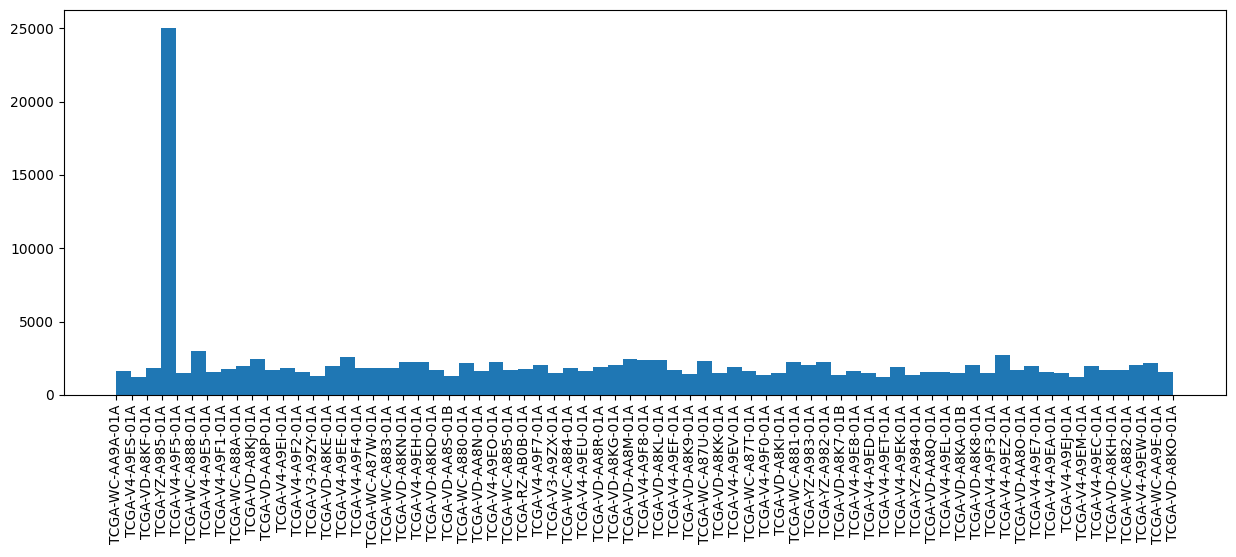

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.hist(df_res.SAMPLE, bins=df_res.SAMPLE.unique().shape[0])
ax.tick_params(axis='x', labelrotation=90)
ids, cts = np.unique(df_res.SAMPLE, return_counts=True)
idx_max = np.argsort(cts)[-1]
print(ids[idx_max] + ': ' + str(cts[idx_max]) + ' number of mutations')
plt.show()

## Excluding outlier

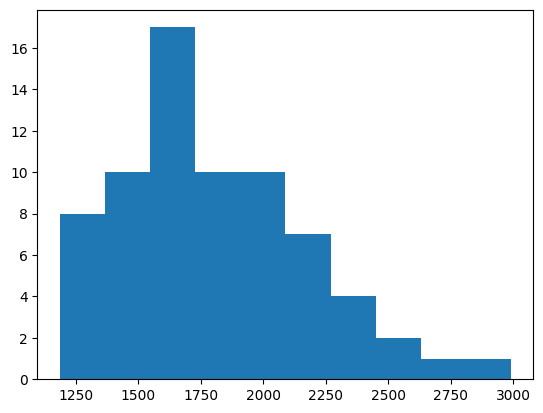

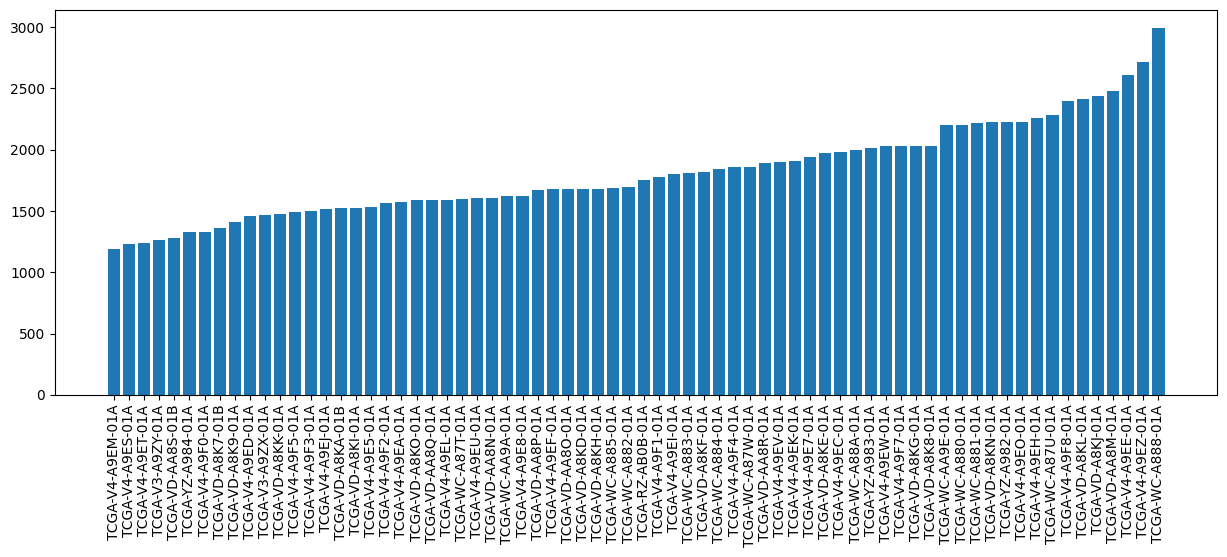

In [13]:
outliers = ['TCGA-YZ-A985-01A']
ids, cts = np.unique(df_res.loc[~df_res.SAMPLE.isin(outliers), 'SAMPLE'], return_counts=True)
plt.hist(cts)
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ind_sorted = np.argsort(cts)
plt.bar(ids[ind_sorted], cts[ind_sorted])
ax.tick_params(axis='x', labelrotation=90)
plt.show()

# DIG output

## Coding genes

In [14]:
df = pd.read_csv('genes.results.txt', sep='\t')

### Output columns

In [15]:
df.columns.tolist()

['GENE',
 'CHROM',
 'GENE_LENGTH',
 'R_SIZE',
 'R_OBS',
 'R_INDEL',
 'MU',
 'SIGMA',
 'ALPHA',
 'THETA',
 'MU_INDEL',
 'SIGMA_INDEL',
 'ALPHA_INDEL',
 'THETA_INDEL',
 'FLAG',
 'Pi_SYN',
 'Pi_MIS',
 'Pi_NONS',
 'Pi_SPL',
 'Pi_TRUNC',
 'Pi_NONSYN',
 'Pi_INDEL',
 'OBS_SYN',
 'OBS_MIS',
 'OBS_NONS',
 'OBS_SPL',
 'OBS_INDEL',
 'OBS_TRUNC',
 'OBS_NONSYN',
 'N_SAMP_SYN',
 'N_SAMP_MIS',
 'N_SAMP_NONS',
 'N_SAMP_SPL',
 'N_SAMP_TRUNC',
 'N_SAMP_NONSYN',
 'N_SAMP_INDEL',
 'EXP_SYN',
 'EXP_MIS',
 'EXP_NONS',
 'EXP_SPL',
 'EXP_TRUNC',
 'EXP_NONSYN',
 'PVAL_SYN_BURDEN',
 'PVAL_MIS_BURDEN',
 'PVAL_NONS_BURDEN',
 'PVAL_SPL_BURDEN',
 'PVAL_TRUNC_BURDEN',
 'PVAL_NONSYN_BURDEN',
 'PVAL_SYN_BURDEN_SAMPLE',
 'PVAL_MIS_BURDEN_SAMPLE',
 'PVAL_NONS_BURDEN_SAMPLE',
 'PVAL_SPL_BURDEN_SAMPLE',
 'PVAL_TRUNC_BURDEN_SAMPLE',
 'PVAL_NONSYN_BURDEN_SAMPLE',
 'EXP_INDEL',
 'PVAL_INDEL_BURDEN',
 'PVAL_MUT_BURDEN']

### Results for given mutation burden type

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log2



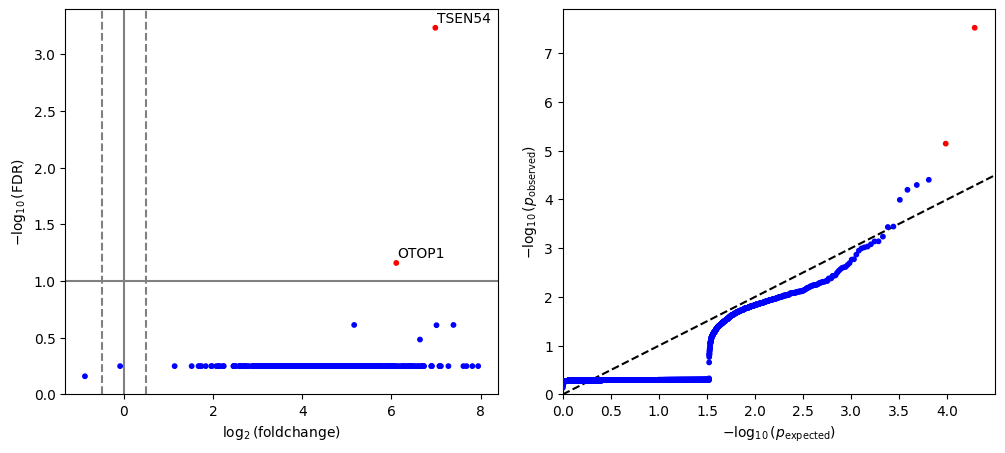

In [16]:
mtype = 'SYN'
d = np.log2(df['OBS_' + mtype]) - np.log2(df['EXP_' + mtype])
p = df['PVAL_' + mtype + '_BURDEN']
l = df.GENE
plot_functions.plot_volcano(p, d, l)

### Distribution of GP parameters

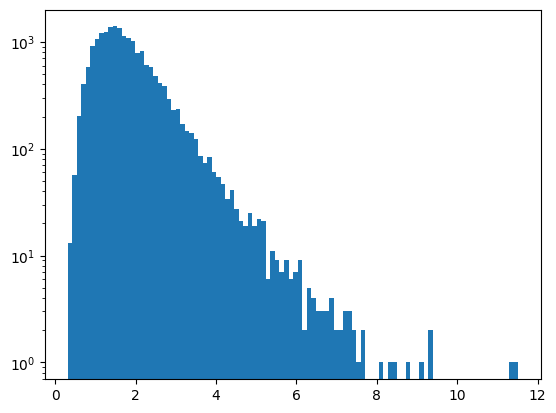

In [17]:
plt.hist(df.SIGMA, bins=100, log=True)
plt.show()

### Recomputing p-values from model parameters

In [18]:
def nb_pvalue_greater_midp(k, alpha, p):
    """ Calculate an UPPER TAIL p-value for a negative binomial distribution with a midp correction
    """
    return 0.5 * sp.stats.nbinom.pmf(k, alpha, p) + sp.special.betainc(k+1, alpha, 1-p)

def nb_pvalue_lower(k, alpha, p):
    return sp.special.betainc(k+1, alpha, 1-p)

def nb_pvalue_upper(k, alpha, p):
    ind_0 = k==0
    pvals = np.zeros_like(alpha)
    pvals[ind_0] = sp.stats.nbinom.pmf(k[ind_0], alpha[ind_0], p[ind_0])
    pvals[~ind_0] = sp.special.betainc(k[~ind_0], alpha[~ind_0], 1-p[~ind_0])
    return pvals

def nb_pvalue_uniform_midp(k, alpha, p):
    """ Calculate the upper tail p-value for negative binomial distribution using uniform approximation and a random draw.
    """
    return np.random.uniform(size=k.shape) * sp.stats.nbinom.pmf(k, alpha, p) + sp.special.betainc(k+1, alpha, 1-p)

#### Total burden

In [19]:
muts = ['SYN', 'MIS', 'NONS', 'TRUNC', 'SPL', 'NONSYN', 'MUT']
print('Minimum and maximum differnces between original and recomputed p-values:\n')
for mut in muts:
    if mut=='MUT':
        col_i = 'PVAL_' + mut + '_BURDEN'
        df[col_i + '_recomp'] = np.nan
        df[col_i + '_uniform'] = np.nan
        for idx in df.index:
            # combining p-values using Fisher's method
            df.at[idx, col_i + '_recomp'] = sp.stats.combine_pvalues([df.at[idx, 'PVAL_NONSYN_BURDEN_recomp'], df.at[idx, 'PVAL_INDEL_BURDEN']], method='fisher').pvalue
            df.at[idx, col_i + '_uniform'] = sp.stats.combine_pvalues([df.at[idx, 'PVAL_NONSYN_BURDEN_uniform'], df.at[idx, 'PVAL_INDEL_BURDEN']], method='fisher').pvalue
    else:
        # recomputing p-values using DIG's model parameters
        df['PVAL_' + mut + '_BURDEN_recomp'] = nb_pvalue_greater_midp(
            df['OBS_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
        df['PVAL_' + mut + '_BURDEN_uniform'] = nb_pvalue_uniform_midp(
                df['OBS_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
    print(mut, np.min(df['PVAL_' + mut + '_BURDEN_recomp'] - df['PVAL_' + mut + '_BURDEN']), np.max(df['PVAL_' + mut + '_BURDEN_recomp'] - df['PVAL_' + mut + '_BURDEN']))
    
df['PVAL_INDEL_BURDEN_recomp'] = nb_pvalue_greater_midp(df.OBS_INDEL, df.ALPHA_INDEL, 1 / (df.THETA_INDEL*df.Pi_INDEL + 1))
df['PVAL_INDEL_BURDEN_uniform'] = nb_pvalue_uniform_midp(df.OBS_INDEL, df.ALPHA_INDEL, 1 / (df.THETA_INDEL*df.Pi_INDEL + 1))
print('INDEL', np.min(df['PVAL_INDEL_BURDEN_recomp'] - df['PVAL_INDEL_BURDEN']), np.max(df['PVAL_INDEL_BURDEN_recomp'] - df['PVAL_INDEL_BURDEN']))

Minimum and maximum differnces between original and recomputed p-values:

SYN -1.170175067954915e-13 7.416289804496046e-14
MIS -2.674527266322002e-13 1.6220358389773537e-13
NONS -3.863576125695545e-14 2.0761170560490427e-14
TRUNC -5.484501741648273e-14 2.6867397195928788e-14
SPL -5.3734794391857577e-14 9.2148511043888e-15
NONSYN -1.2922996006636822e-13 1.6575629757653587e-13
MUT -0.6148743092078043 0.3762246949086101
INDEL -1.5765166949677223e-14 1.432187701766452e-14


#### Sample-wise burden

In [20]:
print('Minimum and maximum differnces between original and recomputed p-values:\n')
for mut in muts:
    if mut=='MUT':
        # racomputing p-values by aggregating mutation burdens
        df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] = nb_pvalue_greater_midp(
            df['N_SAMP_NONSYN'] + df['N_SAMP_INDEL'],
            df.ALPHA,
            1 / (df.THETA * (df['Pi_NONS'] + df['Pi_INDEL']) + 1)
        )
        df['PVAL_' + mut + '_BURDEN_SAMPLE_uniform'] = nb_pvalue_uniform_midp(
            df['N_SAMP_NONSYN'] + df['N_SAMP_INDEL'],
            df.ALPHA,
            1 / (df.THETA * (df['Pi_NONS'] + df['Pi_INDEL']) + 1)
            )    
        print(mut, np.min(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN']), np.max(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN']))
    else:
        df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] = nb_pvalue_greater_midp(
                df['N_SAMP_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
        df['PVAL_' + mut + '_BURDEN_SAMPLE_uniform'] = nb_pvalue_uniform_midp(
                df['N_SAMP_' + mut],
                df.ALPHA,
                1 / (df.THETA * df['Pi_' + mut] + 1)
            )
        print(mut, np.min(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN_SAMPLE']), np.max(df['PVAL_' + mut + '_BURDEN_SAMPLE_recomp'] - df['PVAL_' + mut + '_BURDEN_SAMPLE']))

Minimum and maximum differnces between original and recomputed p-values:

SYN -1.170175067954915e-13 7.416289804496046e-14
MIS -2.674527266322002e-13 1.6220358389773537e-13
NONS -3.863576125695545e-14 2.0761170560490427e-14
TRUNC -5.484501741648273e-14 2.6867397195928788e-14
SPL -5.3734794391857577e-14 9.2148511043888e-15
NONSYN -1.2922996006636822e-13 1.6575629757653587e-13
MUT -0.6137014422602022 0.5246556547050266


### Computing lower and upper bounds for p-values

In [21]:
muts = ['SYN', 'MIS', 'NONS', 'TRUNC', 'SPL', 'NONSYN']
for mut in muts:
    # total burden
    df['PVAL_' + mut + '_BURDEN_lower'] = nb_pvalue_lower(
        df['OBS_' + mut],
        df.ALPHA,
        1 / (df.THETA * df['Pi_' + mut] + 1)
    )
    df['PVAL_' + mut + '_BURDEN_upper'] = nb_pvalue_upper(
        df['OBS_' + mut],
        df.ALPHA,
        1 / (df.THETA * df['Pi_' + mut] + 1)
    )
    # sample-wise burden
    df['PVAL_' + mut + '_BURDEN_SAMPLE_lower'] = nb_pvalue_lower(
            df['N_SAMP_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
    df['PVAL_' + mut + '_BURDEN_SAMPLE_upper'] = nb_pvalue_upper(
            df['N_SAMP_' + mut],
            df.ALPHA,
            1 / (df.THETA * df['Pi_' + mut] + 1)
        )
# total indel burden
df['PVAL_INDEL_BURDEN_lower'] = nb_pvalue_lower(
    df.OBS_INDEL, 
    df.ALPHA, 
    1 / (df.THETA_INDEL * df.Pi_INDEL + 1)
)
df['PVAL_INDEL_BURDEN_upper'] = nb_pvalue_upper(
    df.OBS_INDEL, 
    df.ALPHA, 
    1 / (df.THETA_INDEL * df.Pi_INDEL + 1)
)

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_23966/2892428053.py:2: RuntimeWarning:

divide by zero encountered in log2

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/matplotlib/transforms.py:365: RuntimeWarning:

invalid value encountered in double_scalars



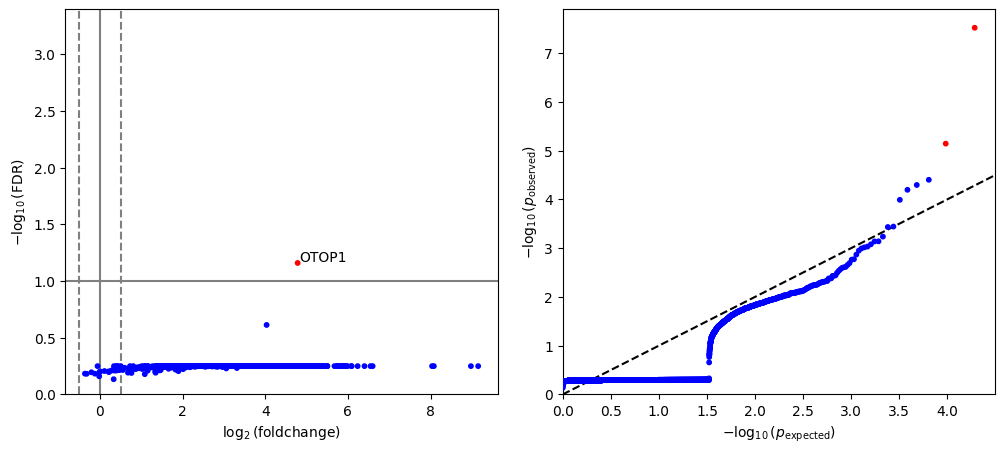

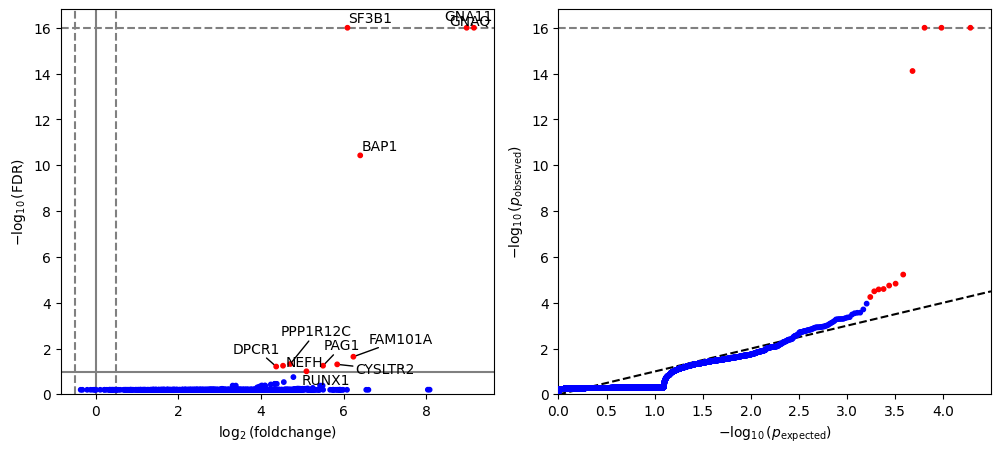

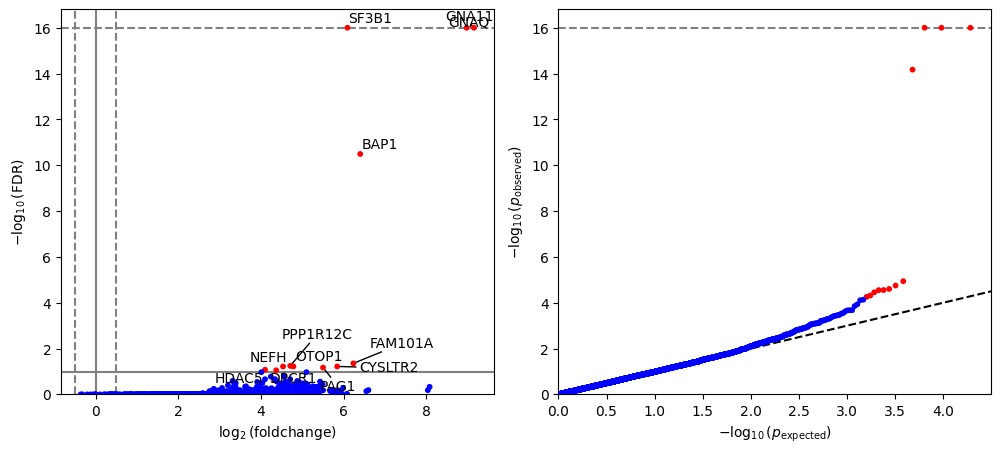

In [22]:
mtype = 'NONSYN'
d = np.log2(df['OBS_' + mtype].to_numpy()) - np.log2(df['EXP_' + mtype].to_numpy())
p_pmid = df['PVAL_' + mtype + '_BURDEN' + '_recomp'].to_numpy()
p_upmid = df['PVAL_' + mtype + '_BURDEN' + '_uniform'].to_numpy()
l = df.GENE.to_numpy()
p_bounds = df[['PVAL_' + mtype + '_BURDEN' + '_lower', 'PVAL_' + mtype + '_BURDEN' + '_upper']].to_numpy()
plot_functions.plot_volcano(p, d, l)
plot_functions.plot_volcano(p_pmid, d, l, ymax_vol=16, ymax_qq=16)
plot_functions.plot_volcano(p_upmid, d, l, ymax_vol=16, ymax_qq=16)

### Q-Q plot for Fisher's combined probability test

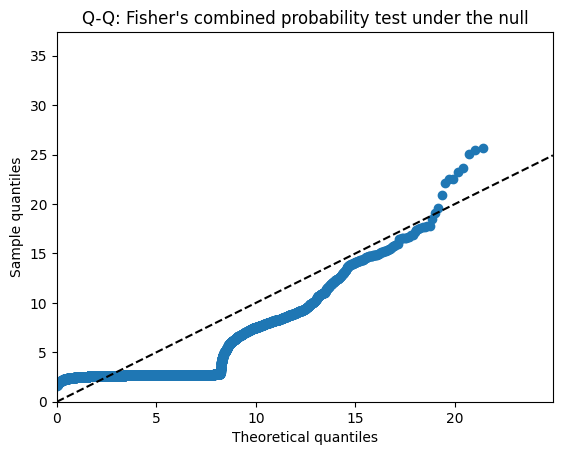

In [23]:
n = df.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df[['PVAL_NONSYN_BURDEN_recomp', 'PVAL_INDEL_BURDEN_recomp']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

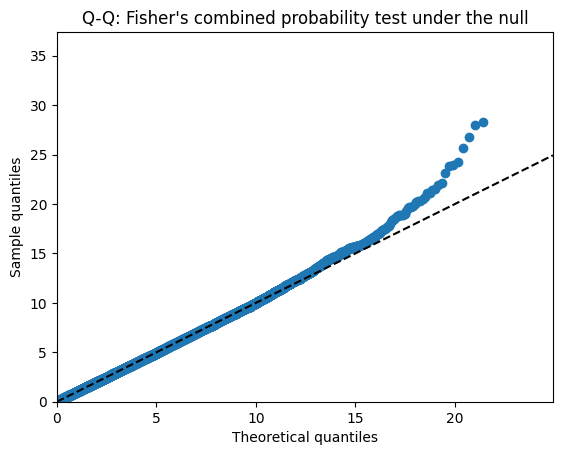

In [24]:
n = df.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df[['PVAL_NONSYN_BURDEN_uniform', 'PVAL_INDEL_BURDEN_uniform']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

## Promoters

In [25]:
df_prom = pd.read_csv('promoters.results.txt', sep='\t')
df_prom.columns.tolist()

['ELT',
 'ELT_SIZE',
 'FLAG',
 'R_SIZE',
 'R_OBS',
 'R_INDEL',
 'MU',
 'SIGMA',
 'ALPHA',
 'THETA',
 'MU_INDEL',
 'SIGMA_INDEL',
 'ALPHA_INDEL',
 'THETA_INDEL',
 'Pi_SUM',
 'Pi_INDEL',
 'OBS_SAMPLES',
 'OBS_SNV',
 'OBS_INDEL',
 'EXP_SNV',
 'PVAL_SNV_BURDEN',
 'PVAL_SAMPLE_BURDEN',
 'EXP_INDEL',
 'PVAL_INDEL_BURDEN',
 'PVAL_MUT_BURDEN']

In [26]:
df_prom['OBS_MUT'] = df_prom['OBS_SNV'] + df_prom['OBS_INDEL']
df_prom['EXP_MUT'] = df_prom['EXP_SNV'] + df_prom['EXP_INDEL']
df_prom['Pi_MUT'] = df_prom['Pi_SUM'] + df_prom['Pi_INDEL']

In [27]:
pfxs_obs = ['SNV', 'INDEL', 'SAMPLES', 'MUT']
pfxs_pval = ['SNV', 'INDEL', 'SAMPLE', 'MUT']
pfxs_pi = ['SUM', 'INDEL', 'SUM', 'MUT']
pfxs_at = ['', '_INDEL', '', '']

for i in range(len(pfxs_obs)):
    if pfxs_pval[i]=='MUT':
        col_i = 'PVAL_' + pfxs_pval[i] + '_BURDEN'
        df_prom[col_i + '_recomp'] = np.nan
        df_prom[col_i + '_uniform'] = np.nan
        df_prom[col_i + '_lower'] = np.nan
        df_prom[col_i + '_upper'] = np.nan
        # combining p-values with Fisher's method
        for idx in df_prom.index:
            df_prom.at[idx, col_i + '_recomp'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_recomp'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_recomp']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_uniform'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_uniform'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_uniform']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_lower'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_lower'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_lower']], method='fisher').pvalue
            df_prom.at[idx, col_i + '_upper'] = sp.stats.combine_pvalues([df_prom.at[idx, 'PVAL_SNV_BURDEN_upper'], df_prom.at[idx, 'PVAL_INDEL_BURDEN_upper']], method='fisher').pvalue
    else:
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] = nb_pvalue_greater_midp(
                df_prom['OBS_' + pfxs_obs[i]],
                df_prom['ALPHA' + pfxs_at[i]],
                1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
            ) 
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_uniform'] = nb_pvalue_uniform_midp(
                df_prom['OBS_' + pfxs_obs[i]],
                df_prom['ALPHA' + pfxs_at[i]],
                1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
            ) 
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_lower'] = nb_pvalue_lower(
            df_prom['OBS_' + pfxs_obs[i]],
            df_prom['ALPHA' + pfxs_at[i]],
            1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
        )
        df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_upper'] = nb_pvalue_upper(
            df_prom['OBS_' + pfxs_obs[i]],
            df_prom['ALPHA' + pfxs_at[i]],
            1 / (df_prom['THETA' + pfxs_at[i]] * df_prom['Pi_' + pfxs_pi[i]] + 1)
        )
    print(pfxs_obs[i], np.min(df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] - df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN']), np.max(df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN_recomp'] - df_prom['PVAL_' + pfxs_pval[i] + '_BURDEN']))

SNV -2.4480417692984702e-14 3.197442310920451e-14
INDEL -1.1435297153639112e-14 2.383510055992133e-15
SAMPLES -2.4480417692984702e-14 3.197442310920451e-14
MUT -2.2370993946196904e-14 1.1712852909795402e-14


/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_23966/4184195437.py:1: RuntimeWarning:

divide by zero encountered in log2

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_23966/4184195437.py:1: RuntimeWarning:

invalid value encountered in subtract

/Users/dlehotzk/Documents/tcga/dig/plot_functions.py:117: RuntimeWarning:

divide by zero encountered in log10

/Users/dlehotzk/Documents/tcga/dig/plot_functions.py:168: RuntimeWarning:

divide by zero encountered in log10



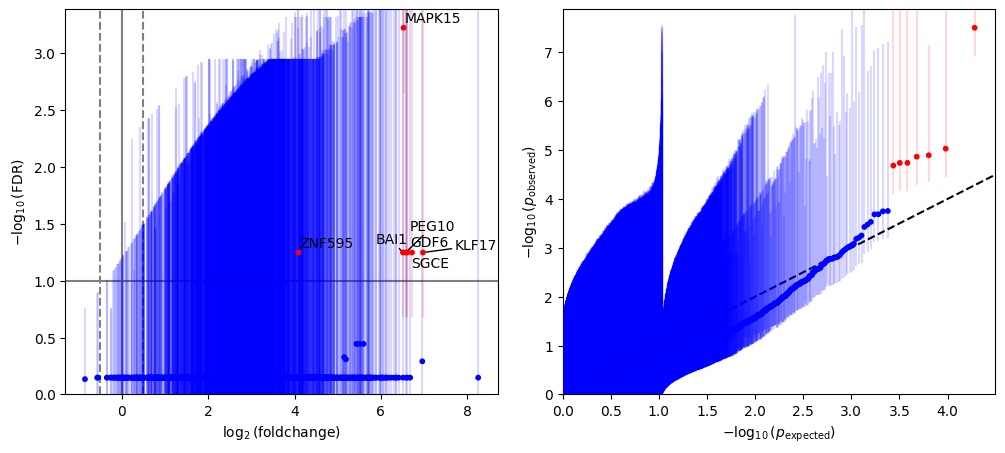

In [28]:
d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
p = df_prom.PVAL_MUT_BURDEN_recomp.to_numpy()
l = np.array([g.split('::')[-2] for g in df_prom.ELT])
plot_functions.plot_volcano(p, d, l, pval_bounds=df_prom[['PVAL_MUT_BURDEN_upper', 'PVAL_MUT_BURDEN_lower']].to_numpy())

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_23966/1981111821.py:1: RuntimeWarning:

divide by zero encountered in log2

/var/folders/7d/ccyblkpj6wvbl5n45y_l75180000gq/T/ipykernel_23966/1981111821.py:1: RuntimeWarning:

invalid value encountered in subtract



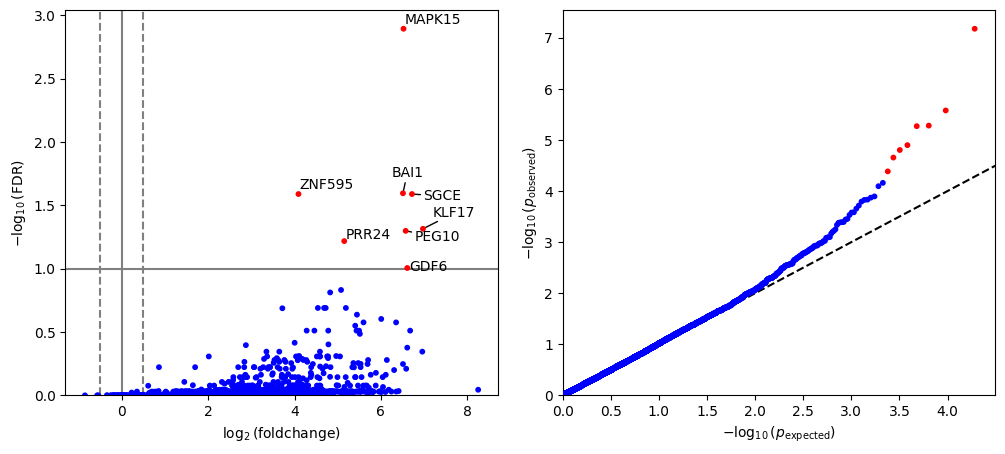

In [29]:
d = np.log2(df_prom.OBS_MUT.to_numpy()) - np.log2(df_prom.EXP_MUT.to_numpy())
p = df_prom.PVAL_MUT_BURDEN_uniform.to_numpy()
l = np.array([g.split('::')[-2] for g in df_prom.ELT])
plot_functions.plot_volcano(p, d, l)

### Q-Q plot for Fisher's combined probability test

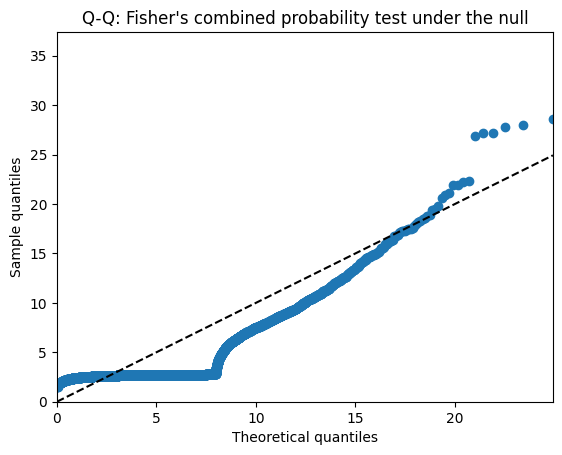

In [30]:
n = df_prom.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df_prom[['PVAL_SNV_BURDEN', 'PVAL_INDEL_BURDEN']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

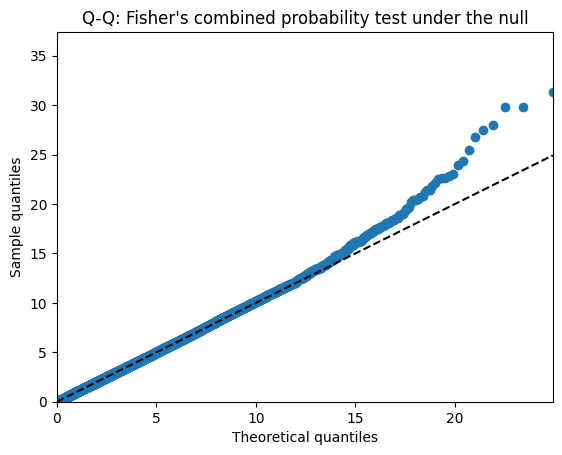

In [31]:
n = df_prom.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=4)
Y = np.sort(-2 * np.log(df_prom[['PVAL_SNV_BURDEN_uniform', 'PVAL_INDEL_BURDEN_uniform']].to_numpy()).sum(axis=1))
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 1.5 * X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

# Combining evidence from different regions for each gene

In [32]:
dig_outputs = {
    'coding': 'genes.results.txt',
    'promoter': 'promoters.results.txt',
    '3utr': '3utr.results.txt',
    '5utr': '5utr.results.txt'
}

result_types = list(dig_outputs.keys())
for result_type in result_types:
    
    dfi = pd.read_csv(dig_outputs[result_type], sep='\t')
    
    if result_type == 'coding':
        dfi = dfi.set_index('GENE')
        df_comb = pd.DataFrame(index = dfi.index.copy())
        col_obs = ['OBS_NONSYN', 'N_SAMP_NONSYN', 'OBS_INDEL']
        col_pi = ['Pi_NONSYN', 'Pi_NONSYN', 'Pi_INDEL']
        col_size = 'GENE_LENGTH'
    else:
        dfi['GENE'] = dfi.ELT.str.split('::', expand=True)[2]
        dfi = dfi.sort_values(['GENE', 'OBS_SNV'])
        dfi = dfi.set_index('GENE')
        dfi = dfi.loc[~dfi.index.duplicated()]
        col_obs = ['OBS_SNV', 'OBS_SAMPLES', 'OBS_INDEL']
        col_pi = ['Pi_SUM', 'Pi_SUM', 'Pi_INDEL']
        col_size = 'ELT_SIZE'

    genes_in_coding = dfi.index[dfi.index.isin(df_comb.index)]
    dfi_comp = dfi.loc[genes_in_coding]
    df_comb.loc[genes_in_coding, 'SIZE_' + result_type] = dfi_comp[col_size].to_numpy().copy()
        
    for j, mt in enumerate(['SNV', 'SNV_SAMPLE', 'INDEL']):
    
        if mt == 'INDEL':
            pfx_at = '_INDEL'
        else:
            pfx_at = ''
        df_comb.loc[genes_in_coding, 'PVAL_' + result_type + '_' + mt + '_recalc'] = nb_pvalue_greater_midp(
            dfi_comp[col_obs[j]],
            dfi_comp['ALPHA' + pfx_at],
            1 / (dfi_comp['THETA' + pfx_at] * dfi_comp[col_pi[j]] + 1)
        )
        df_comb.loc[genes_in_coding, 'PVAL_' + result_type + '_' + mt + '_unif'] = nb_pvalue_uniform_midp(
            dfi_comp[col_obs[j]],
            dfi_comp['ALPHA' + pfx_at],
            1 / (dfi_comp['THETA' + pfx_at] * dfi_comp[col_pi[j]] + 1)
        )
        df_comb.loc[genes_in_coding, 'PVAL_' + result_type + '_' + mt + '_lower'] = nb_pvalue_lower(
            dfi_comp[col_obs[j]],
            dfi_comp['ALPHA' + pfx_at],
            1 / (dfi_comp['THETA' + pfx_at] * dfi_comp[col_pi[j]] + 1)
        )
        df_comb.loc[genes_in_coding, 'PVAL_' + result_type + '_' + mt + '_upper'] = nb_pvalue_upper(
            dfi_comp[col_obs[j]],
            dfi_comp['ALPHA' + pfx_at],
            1 / (dfi_comp['THETA' + pfx_at] * dfi_comp[col_pi[j]] + 1)
        )
    
    # combining p-values with Fisher's method
    col_i = 'PVAL_' + result_type + '_' + 'MUT'
    df_comb[col_i + '_recalc'] = np.nan
    df_comb[col_i + '_unif'] = np.nan
    df_comb[col_i + '_lower'] = np.nan
    df_comb[col_i + '_upper'] = np.nan
    for idx in df_comb.index:
        df_comb.at[idx, col_i + '_recalc'] = sp.stats.combine_pvalues([df_comb.at[idx, 'PVAL_' + result_type + '_SNV_recalc'], df_comb.at[idx, 'PVAL_' + result_type + '_INDEL_recalc']], method='fisher')[1]
        df_comb.at[idx, col_i + '_unif'] = sp.stats.combine_pvalues([df_comb.at[idx, 'PVAL_' + result_type + '_SNV_unif'], df_comb.at[idx, 'PVAL_' + result_type + '_INDEL_unif']], method='fisher')[1]
        df_comb.at[idx, col_i + '_lower'] = sp.stats.combine_pvalues([df_comb.at[idx, 'PVAL_' + result_type + '_SNV_lower'], df_comb.at[idx, 'PVAL_' + result_type + '_INDEL_lower']], method='fisher')[1]
        df_comb.at[idx, col_i + '_upper'] = sp.stats.combine_pvalues([df_comb.at[idx, 'PVAL_' + result_type + '_SNV_upper'], df_comb.at[idx, 'PVAL_' + result_type + '_INDEL_upper']], method='fisher')[1]

# combining p-values across region types
for mt in ['SNV', 'SNV_SAMPLE', 'INDEL', 'MUT']:
    for typ in ['recalc', 'unif', 'lower', 'upper']:
        for idx in df_comb.index:
            df_comb.at[idx, 'PVAL_' + mt + '_' + typ] = sp.stats.combine_pvalues(
            [df_comb.at[idx, 'PVAL_' + rt + '_' + mt + '_' + typ] for rt in result_types if ~np.isnan(df_comb.at[idx, 'PVAL_' + rt + '_' + mt + '_' + typ])], 
            method='fisher')[1]
        isna = df_comb['PVAL_' + mt + '_' + typ].isna()
        df_comb.loc[~isna, 'FDR_' + mt + '_' + typ] = fdrcorrection(df_comb.loc[~isna, 'PVAL_' + mt + '_' + typ])[1]

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log

/Users/dlehotzk/anaconda3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



In [33]:
df_comb

,SIZE_coding,PVAL_coding_SNV_recalc,PVAL_coding_SNV_unif,PVAL_coding_SNV_lower,PVAL_coding_SNV_upper,PVAL_coding_SNV_SAMPLE_recalc,PVAL_coding_SNV_SAMPLE_unif,PVAL_coding_SNV_SAMPLE_lower,PVAL_coding_SNV_SAMPLE_upper,PVAL_coding_INDEL_recalc,...,PVAL_INDEL_upper,FDR_INDEL_upper,PVAL_MUT_recalc,FDR_MUT_recalc,PVAL_MUT_unif,FDR_MUT_unif,PVAL_MUT_lower,FDR_MUT_lower,PVAL_MUT_upper,FDR_MUT_upper
GENE,,,,,,,,,,,,,,,,,,,,,
A1BG,1488.0,0.539230,0.888620,0.078459,0.921541,0.539230,0.257851,0.078459,0.921541,0.501861,...,1.000000,1.0,0.858069,0.921369,0.981912,0.999923,1.107975e-11,1.009687e-10,1.000000,1.0
A1CF,1785.0,0.546922,0.238456,0.093844,0.906156,0.546922,0.656277,0.093844,0.906156,0.502198,...,1.000000,1.0,0.894464,0.921369,0.335311,0.999841,2.922788e-07,3.504792e-07,0.999998,1.0
A2M,4425.0,0.627229,0.677546,0.254459,0.745541,0.627229,0.374661,0.254459,0.745541,0.506623,...,0.999999,1.0,0.847140,0.921369,0.324363,0.999841,7.296373e-06,7.582954e-06,0.999985,1.0
A2ML1,4365.0,0.598584,0.827728,0.197168,0.802832,0.598584,0.528897,0.197168,0.802832,0.505130,...,1.000000,1.0,0.889448,0.921369,0.794263,0.999841,3.202935e-07,3.815477e-07,1.000000,1.0
A3GALT2,1023.0,0.529251,0.340636,0.058503,0.941497,0.529251,0.293646,0.058503,0.941497,0.501217,...,0.999955,1.0,0.762110,0.921369,0.638011,0.999841,1.231459e-04,1.242193e-04,0.999942,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYX,1719.0,0.547539,0.355534,0.095079,0.904921,0.547539,0.301790,0.095079,0.904921,0.502365,...,1.000000,1.0,0.872100,0.921369,0.579512,0.999841,2.596297e-08,3.971246e-08,1.000000,1.0
ZZEF1,8886.0,0.697706,0.637650,0.395411,0.604589,0.697706,0.722043,0.395411,0.604589,0.511440,...,1.000000,1.0,0.657883,0.921369,0.555044,0.999841,1.357497e-07,1.730082e-07,0.985464,1.0
ZZZ3,2712.0,0.570808,0.785013,0.141616,0.858384,0.570808,0.596077,0.141616,0.858384,0.503479,...,1.000000,1.0,0.613934,0.921369,0.643294,0.999841,7.550878e-08,1.020346e-07,0.988930,1.0


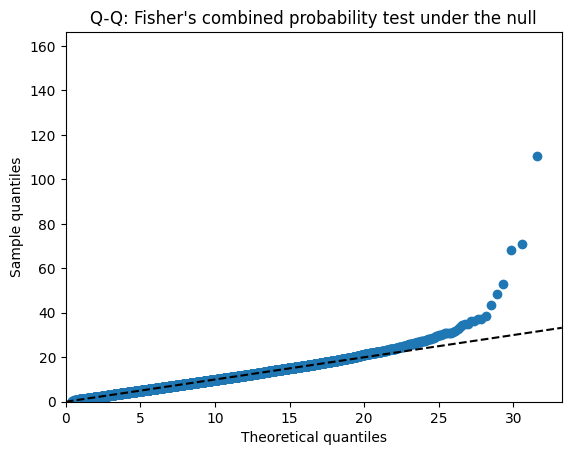

In [34]:
Y = np.sort(-2 * np.log(df_comb[['PVAL_' + rt + '_SNV_unif' for rt in result_types]].to_numpy()).sum(axis=1))
Y = Y[~np.isnan(Y)]
n = Y.shape[0]
X = sp.stats.chi2.ppf((np.arange(n-1) + 1) / n, df=8)
plt.scatter(X, Y[:-1])
plt.plot([0, X.max()], [0, X.max()], 'k--')
plt.xlim([0, X.max()])
plt.ylim([0, 5*X.max()])
plt.title('Q-Q: Fisher\'s combined probability test under the null')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()